<a href="https://colab.research.google.com/github/ttqureshi/Movie-Reviews-Classification/blob/main/module1_project1_movie_review_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

# Importing Libraries

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data")

Skipping, found downloaded files in "./imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


In [ ]:
import concurrent.futures
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string

from bs4 import BeautifulSoup
from collections import Counter
from gensim.models import Word2Vec, KeyedVectors
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from wordcloud import WordCloud


In [ ]:
df = pd.read_csv("/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data Cleaning


In [ ]:
# checking missing values
df.isnull().sum()

,0
review,0
sentiment,0


In [ ]:
# checking for duplicates
df.duplicated().sum()

418

Here we see there are 418 duplicate rows. Let's remove duplicates

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Now there are no duplicates.

In [ ]:
# Now encoding the target variable
le = LabelEncoder()
le.fit(df["sentiment"])
le.classes_

array(['negative', 'positive'], dtype=object)

In [ ]:
df['y'] = le.transform(df.sentiment)
df.head()

,review,sentiment,y
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


# Text Preprocessing

In [ ]:
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()


In [ ]:
def preprocess_text(text):
    """
    Takes in a review as `text` to be processed. Applies the following preprocessing
    steps
    - Lowercasing
    - Remove HTML tags
    - Removing special characters
    - Tokenization
    - Stop words removal
    - Lemmatization
    and returns the processed text.
    """

    # Lowercasing
    text = text.lower()

    # Remove HTML tags
    pattern = re.compile("<.*?>")
    text = pattern.sub(r'', text)

    # Special characters removal
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Tokenization
    word_tokens = text.split()

    # Stop Words removal
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in word_tokens if word not in stop_words]

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word, pos="v") for word in filtered_words]

    processed_text = " ".join(lemmatized_words)

    return processed_text



In [ ]:
# testing if the above function works as needed
review = df['review'][1]
print(review)
print(">>> After Processing...")
preprocess_text(review)

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.
>

'wonderful little production film technique unassuming oldtimebbc fashion give comfort sometimes discomforting sense realism entire piece actors extremely well choose michael sheen get polari voice pat truly see seamless edit guide reference williams diary entries well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little things fantasy guard rather use traditional dream techniques remain solid disappear play knowledge sense particularly scenes concern orton halliwell set particularly flat halliwells murals decorate every surface terribly well do'

In [ ]:
df['processed_review'] = df['review'].apply(preprocess_text)
df.head()

,review,sentiment,y,processed_review
0,One of the other reviewers has mentioned that ...,positive,1,one reviewers mention watch 1 oz episode youll...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,positive,1,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,0,basically theres family little boy jake think ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter matteis love time money visually stun f...


# EDA

## Data Statistics

In [ ]:
df.describe()

,y
count,49582.000000
mean,0.501876
std,0.500002
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review            49582 non-null  object
 1   sentiment         49582 non-null  object
 2   y                 49582 non-null  int64 
 3   processed_review  49582 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,24884
negative,24698


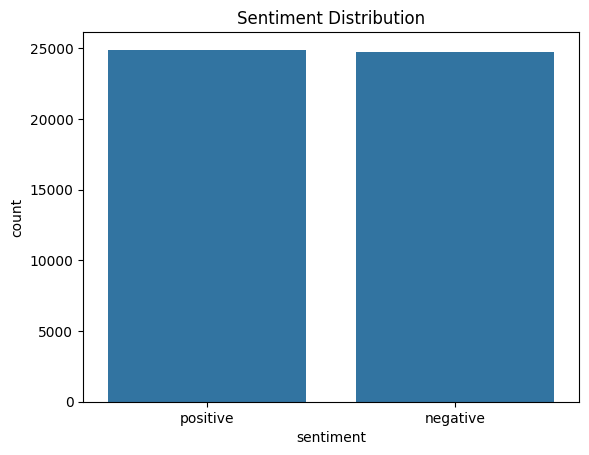

In [ ]:
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.show()


*The dataset is balanced between classes.*



## `review`s length

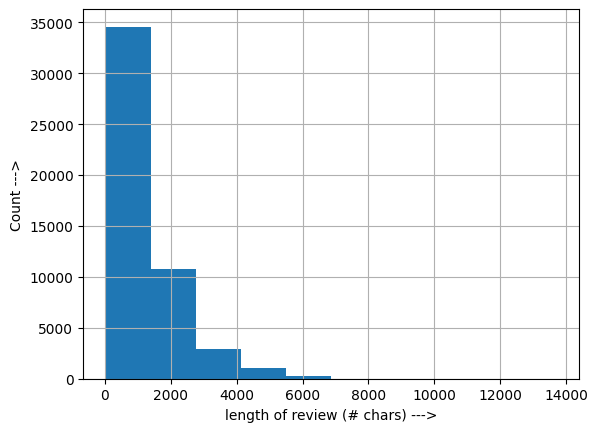

In [ ]:
df['review'].str.len().hist()

plt.xlabel("length of review (# chars) --->")
plt.ylabel("Count --->")
plt.show()

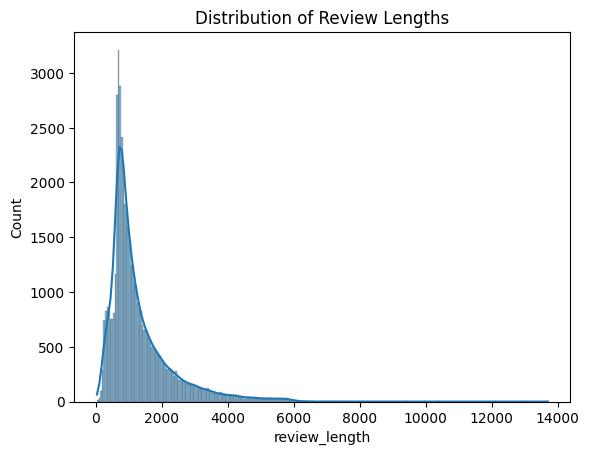

In [ ]:
df['review_length'] = df['review'].apply(len)

# Plot the distribution of review lengths
sns.histplot(df['review_length'], kde=True)
plt.title('Distribution of Review Lengths')
plt.show()


In [ ]:
df.head()

,review,sentiment,y,processed_review,review_length
0,One of the other reviewers has mentioned that ...,positive,1,one reviewers mention watch 1 oz episode youll...,1761
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production film technique una...,998
2,I thought this was a wonderful way to spend ti...,positive,1,think wonderful way spend time hot summer week...,926
3,Basically there's a family where a little boy ...,negative,0,basically theres family little boy jake think ...,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter matteis love time money visually stun f...,1317


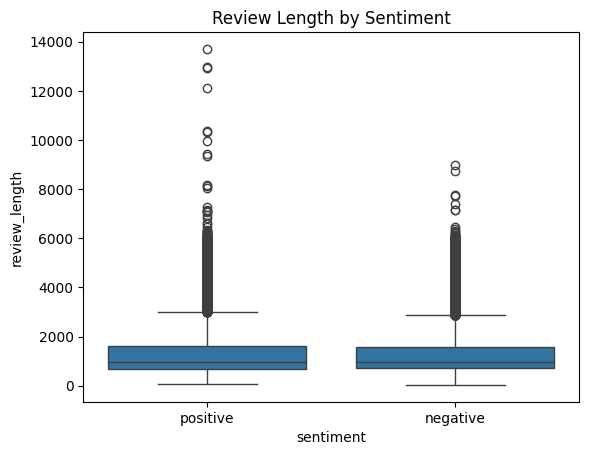

In [ ]:
# Review length by sentiment
sns.boxplot(data=df, x='sentiment', y='review_length')
plt.title('Review Length by Sentiment')
plt.show()

*This shows the median `review_length` for both classes is same around 1000.*

In [ ]:
le.inverse_transform([0, 1, 1])

array(['negative', 'positive', 'positive'], dtype=object)

## WordCloud

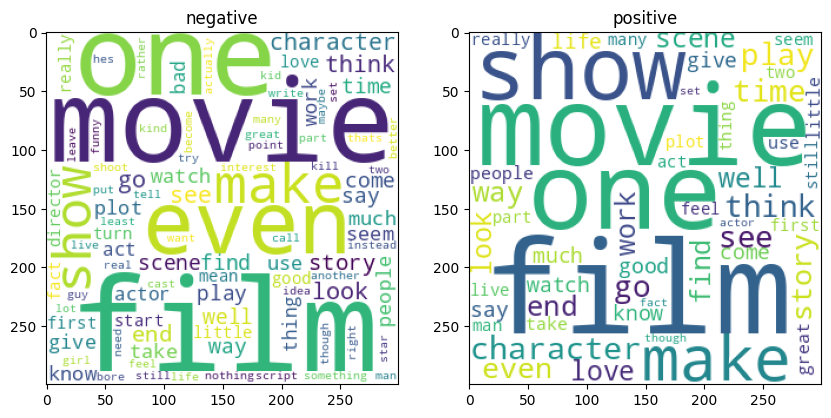

In [ ]:
wc = WordCloud(width=300, height=300, min_font_size=10, background_color='white')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,12))
for i in range(len(df['sentiment'].unique())):
    ax = axs[i]
    cloud = wc.generate(
        df[df['y'] == i]['processed_review'].str.cat(sep=" ")
    )
    ax.imshow(cloud)
    ax.set_title(le.inverse_transform([i])[0])

plt.show()

## Top words

In [ ]:
# Now creating a corpus which will be a 2D list where each row corresponds to a
# category (positive and negative)

corpus = []

for i in range(len(df['sentiment'].unique())):
    corpus_i = []
    for review in df[df['y'] == i]['processed_review'].tolist():
        for word in review.split():
            corpus_i.append(word)
    corpus.append(corpus_i)

print(len(corpus))

2


In [ ]:
neg_df = pd.DataFrame(Counter(corpus[0]).most_common(40))
neg_df.rename(columns={0:'word',1:'count'},inplace=True)
neg_df.head(10)

,word,count
0,movie,47012
1,film,42591
2,one,24365
3,make,23544
4,like,23203
5,see,19085
6,get,19015
7,even,14921
8,watch,14378
9,go,14351


In [ ]:
pos_df = pd.DataFrame(Counter(corpus[1]).most_common(40))
pos_df.rename(columns={0:'word',1:'count'},inplace=True)
pos_df.head(10)

,word,count
0,film,48842
1,movie,35836
2,one,25621
3,see,21200
4,make,20062
5,like,19367
6,get,15873
7,time,15363
8,good,14286
9,character,13565


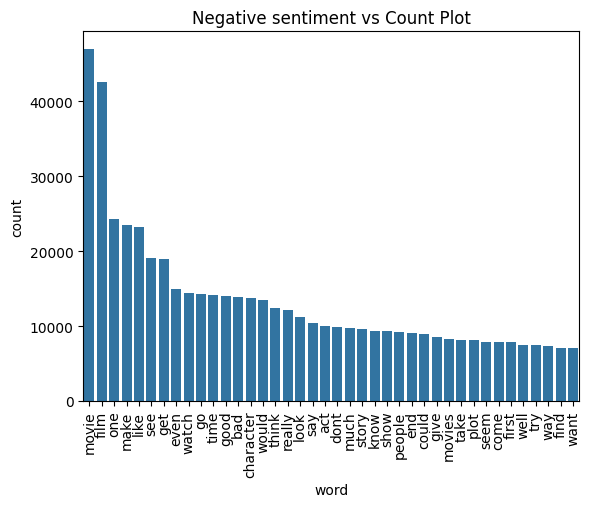

In [ ]:
sns.barplot(x=neg_df['word'],y=neg_df['count'])
plt.xticks(rotation='vertical')
plt.title("Negative sentiment vs Count Plot")
plt.show()

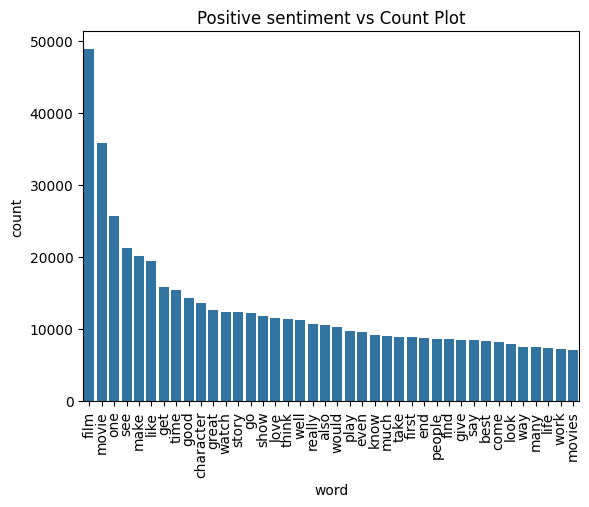

In [ ]:
sns.barplot(x=pos_df['word'],y=pos_df['count'])
plt.xticks(rotation='vertical')
plt.title("Positive sentiment vs Count Plot")
plt.show()

# Classifiers

In [ ]:
mnb = MultinomialNB()
lr = LogisticRegression(max_iter=1000)

In [ ]:
clfs = {
    'mnb': mnb,
    'lr': lr
}

In [ ]:
def train_clfs_and_predict(clfs,X_train,X_test,y_train,y_test):
    acc = {}
    prec = {}
    recall = {}
    f1 = {}
    conf_mat = {}
    classification_rep = {}

    for clf in clfs:
        model = clfs[clf]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        acc[clf] = accuracy_score(y_test,y_pred)
        prec[clf] = precision_score(y_test,y_pred)
        recall[clf] = recall_score(y_test,y_pred)
        f1[clf] = f1_score(y_test,y_pred)
        conf_mat[clf] = confusion_matrix(y_test,y_pred)
        classification_rep[clf] = classification_report(y_test,y_pred)


    return acc, prec, recall, f1, conf_mat, classification_rep

In [ ]:
def print_model_performance(accuracy, precision, recall, f1, conf_mat, classification_rep):
    print(f"Accuracy: {accuracy}\n--------------\n")
    print(f"Precision: {precision}\n--------------\n")
    print(f"Recall: {recall}\n--------------\n")
    print(f"F1 Score: {f1}\n--------------\n")
    print(f"Confusion Matrix MNB:\n {conf_mat['mnb']}\n--------------\n")
    print(f"Confusion Matrix LR:\n {conf_mat['lr']}\n--------------\n")
    print(f"Classification Report MNB:\n {classification_rep['mnb']}\n--------------\n")
    print(f"Classification Report LR:\n {classification_rep['lr']}\n--------------\n")

# Feature Extraction

In [ ]:
y = df['y'].values
y.shape

(49582,)

## Bag Of Words (BOW)

In [ ]:
cv = CountVectorizer()

X_bow = cv.fit_transform(df['processed_review'])
X_bow.shape

(49582, 208583)

In [ ]:
X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_bow_train,y_train)

MultinomialNB()

In [ ]:
accuracy, precision, recall, f1, conf_mat, classification_rep_bow = train_clfs_and_predict(clfs,X_bow_train,X_bow_test,y_train,y_test)

In [ ]:
print_model_performance(accuracy, precision, recall, f1, conf_mat, classification_rep_bow)

Accuracy: {'mnb': 0.8572148835333266, 'lr': 0.8844408591307855}
--------------

Precision: {'mnb': 0.8699626090569174, 'lr': 0.8780584056827151}
--------------

Recall: {'mnb': 0.8413017276014464, 'lr': 0.8939333065488148}
--------------

F1 Score: {'mnb': 0.8553921568627451, 'lr': 0.885924746167629}
--------------

Confusion Matrix MNB:
 [[4313  626]
 [ 790 4188]]
--------------

Confusion Matrix LR:
 [[4321  618]
 [ 528 4450]]
--------------

Classification Report MNB:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      4939
           1       0.87      0.84      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

--------------

Classification Report LR:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.88      0.89      0.89 

## N-grams

In [ ]:
cv_bigram = CountVectorizer(ngram_range=(2,2))

X_bigram = cv_bigram.fit_transform(df['processed_review'])
X_bigram.shape

(49582, 2956837)

In [ ]:
X_bigram_train, X_bigram_test, y_train, y_test = train_test_split(X_bigram, y, test_size=0.2, random_state=42)

In [ ]:
accuracy, precision, recall, f1, conf_mat, classification_rep_bigram = train_clfs_and_predict(clfs,X_bigram_train,X_bigram_test,y_train,y_test)

In [ ]:
print_model_performance(accuracy, precision, recall, f1, conf_mat, classification_rep_bigram)

Accuracy: {'mnb': 0.8698195018654835, 'lr': 0.8569123726933549}
--------------

Precision: {'mnb': 0.8945003209929382, 'lr': 0.8417514883810255}
--------------

Recall: {'mnb': 0.8396946564885496, 'lr': 0.8804740859783046}
--------------

F1 Score: {'mnb': 0.8662314786032536, 'lr': 0.8606774668630339}
--------------

Confusion Matrix MNB:
 [[4446  493]
 [ 798 4180]]
--------------

Confusion Matrix LR:
 [[4115  824]
 [ 595 4383]]
--------------

Classification Report MNB:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      4939
           1       0.89      0.84      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917

--------------

Classification Report LR:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      4939
           1       0.84      0.88      0.86

## TF-IDF

In [ ]:
tfidf = TfidfVectorizer()

X_tfidf = tfidf.fit_transform(df['processed_review'])
X_tfidf.shape

(49582, 208583)

In [ ]:
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
accuracy, precision, recall, f1, conf_mat, classification_rep_tfidf = train_clfs_and_predict(clfs,X_tfidf_train,X_tfidf_test,y_train,y_test)

In [ ]:
print_model_performance(accuracy, precision, recall, f1, conf_mat, classification_rep_tfidf)


Accuracy: {'mnb': 0.8642734697993345, 'lr': 0.8899868911969345}
--------------

Precision: {'mnb': 0.8682076236820763, 'lr': 0.8784810126582279}
--------------

Recall: {'mnb': 0.8601848131779831, 'lr': 0.9061872237846524}
--------------

F1 Score: {'mnb': 0.8641775983854693, 'lr': 0.8921190546820924}
--------------

Confusion Matrix MNB:
 [[4289  650]
 [ 696 4282]]
--------------

Confusion Matrix LR:
 [[4315  624]
 [ 467 4511]]
--------------

Classification Report MNB:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      4939
           1       0.87      0.86      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

--------------

Classification Report LR:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      4939
           1       0.88      0.91      0.89

## Word2Vec

### Training custom word2vec model

In [ ]:
w2v_model = Word2Vec(
    window=10,
    min_count=2,
    vector_size=100
)

In [ ]:
story = [word_tokenize(review) for review in df['processed_review'].tolist()]

In [ ]:
w2v_model.build_vocab(story)

In [ ]:
print(w2v_model.corpus_count)

49582


In [ ]:
w2v_model.train(
    story,
    total_examples=w2v_model.corpus_count,
    epochs=w2v_model.epochs,
)

(27400294, 29738550)

In [ ]:
w2v_model.save('word2vec.model')

In [ ]:
w2v_model.wv["movie"]

array([-0.10282874, -0.68334424, -3.3768044 , -0.08844095,  2.8383944 ,
        0.6947987 ,  0.0714033 , -1.2887304 , -2.0110967 , -2.5607598 ,
        1.831713  ,  1.4518229 ,  0.10586644,  1.885688  , -0.6292039 ,
        0.99206704,  2.703506  ,  2.9611723 , -1.5450878 ,  0.25091732,
       -1.4273771 ,  0.16407855,  0.80311805, -3.1535518 , -0.7262902 ,
        1.5308563 , -2.6738408 ,  1.4334712 , -0.53248054, -0.7120293 ,
       -0.17037845,  0.22880594, -0.71598446, -2.7009954 , -0.5621046 ,
       -0.32887307, -1.6176744 , -0.9607651 , -0.44339487,  1.7586793 ,
        3.5932972 , -0.6326031 , -0.9565507 ,  0.5757439 , -0.75944936,
       -0.83816683,  1.9802188 , -2.434619  ,  0.17362055,  0.84233516,
        1.6736114 ,  0.1439069 ,  0.8501302 ,  2.8200324 ,  1.7962013 ,
        0.24525191,  2.2279708 ,  0.5099787 , -1.2027572 , -0.49640083,
       -1.25237   , -1.005479  ,  0.74258804,  0.08011893, -1.2710015 ,
       -0.93483293,  2.5048864 ,  0.7904077 ,  0.03801067, -0.62

In [ ]:
w2v_model.wv.most_similar("movie")

[('moviei', 0.6736383438110352),
 ('movies', 0.6598963141441345),
 ('film', 0.6571310758590698),
 ('itthe', 0.5618806481361389),
 ('filmi', 0.5483931303024292),
 ('iti', 0.5481629371643066),
 ('flick', 0.5441523790359497),
 ('moviethe', 0.5384331941604614),
 ('really', 0.5326409339904785),
 ('think', 0.5280978083610535)]

In [ ]:
w2v_model.wv.most_similar("good")

[('decent', 0.7319052219390869),
 ('great', 0.6689924597740173),
 ('nice', 0.6661763191223145),
 ('bad', 0.6109643578529358),
 ('okay', 0.6007792353630066),
 ('ok', 0.5904313325881958),
 ('cool', 0.5758578181266785),
 ('alright', 0.5740148425102234),
 ('fair', 0.5737534165382385),
 ('fine', 0.5630952715873718)]

In [ ]:
w2v_model.wv.most_similar("bad")

[('terrible', 0.7596043944358826),
 ('horrible', 0.7464426755905151),
 ('awful', 0.7393715977668762),
 ('lousy', 0.6961624622344971),
 ('crappy', 0.6604300141334534),
 ('suck', 0.6282625794410706),
 ('atrocious', 0.6253849864006042),
 ('lame', 0.6241565942764282),
 ('good', 0.6109643578529358),
 ('stink', 0.6106317043304443)]

### sentence vectorization

In [ ]:
def get_sentence_vector(sent):
    vector_size = w2v_model.vector_size
    vector = np.zeros(vector_size)

    count = 0
    for word in sent.split():
        if word in w2v_model.wv:
            vector += w2v_model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

In [ ]:
get_sentence_vector(df['processed_review'][0])

array([-0.35524679,  0.35322021, -0.14835936, -0.38788291,  0.34956285,
       -0.00770031, -0.1238625 ,  0.12567809, -0.22850689, -0.27554275,
        0.36288062, -0.23273985,  0.18657338, -0.11602114,  0.25756759,
       -0.29043089,  0.7147053 ,  0.02783676, -0.62266951, -0.13020486,
        0.15135958, -0.07616186,  0.01416721, -0.26262286,  0.13931087,
        0.44943884, -0.23600647,  0.0815493 ,  0.05318044, -0.05770707,
       -0.41328895,  0.23948091, -0.41920212, -0.23024513, -0.02734073,
       -0.12884183, -0.11530439, -0.38266843, -0.35835046, -0.1261018 ,
        0.17216473, -0.50475327,  0.50703368, -0.05241911,  0.02744991,
       -0.3498284 , -0.72597221, -0.42300564,  0.10538755,  0.69270424,
        0.38596959, -0.08049913,  0.53781869,  0.12453038,  0.25374865,
       -0.10675401,  0.32689172,  0.30791475, -0.56112831,  0.18571163,
       -0.2389746 , -0.29185345,  0.106962  , -0.16009053, -0.47974617,
       -0.3840237 ,  0.04477749,  0.27615091, -0.50545426,  0.47

In [ ]:
df["w2v_vector"] = df['processed_review'].apply(get_sentence_vector)

In [ ]:
df.head()

,review,sentiment,y,processed_review,review_length,w2v_vector
0,One of the other reviewers has mentioned that ...,positive,1,one reviewers mention watch 1 oz episode youll...,1761,"[-0.3552467912435532, 0.3532202095329536, -0.1..."
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production film technique una...,998,"[0.08843003222603857, 0.11917686786640573, -0...."
2,I thought this was a wonderful way to spend ti...,positive,1,think wonderful way spend time hot summer week...,926,"[-0.11366711360900554, 0.3697169113086623, -0...."
3,Basically there's a family where a little boy ...,negative,0,basically theres family little boy jake think ...,748,"[-0.6299753605101545, 0.026265622589450616, -0..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter matteis love time money visually stun f...,1317,"[-0.0053409931887338155, 0.42717477471756626, ..."


In [ ]:
X_w2v = np.array(df['w2v_vector'].tolist())
X_w2v.shape

(49582, 100)

In [ ]:
X_w2v_train, X_w2v_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [ ]:
# Since the data contains negative values and MNB can't deal with them therefore
# using MinMaxScaler to normalize features
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_w2v_train_scaled = mms.fit_transform(X_w2v_train)

X_w2v_test_scaled = mms.fit_transform(X_w2v_test)

In [ ]:
accuracy, precision, recall, f1, conf_mat, classification_rep_w2v = train_clfs_and_predict(clfs,X_w2v_train_scaled,X_w2v_test_scaled,y_train,y_test)

In [ ]:
print_model_performance(accuracy, precision, recall, f1, conf_mat, classification_rep_w2v)


Accuracy: {'mnb': 0.7483109811434909, 'lr': 0.8318039729756983}
--------------

Precision: {'mnb': 0.7400386847195358, 'lr': 0.9164569703069955}
--------------

Recall: {'mnb': 0.7685817597428686, 'lr': 0.7316191241462434}
--------------

F1 Score: {'mnb': 0.7540402049664958, 'lr': 0.8136729222520107}
--------------

Confusion Matrix MNB:
 [[3595 1344]
 [1152 3826]]
--------------

Confusion Matrix LR:
 [[4607  332]
 [1336 3642]]
--------------

Classification Report MNB:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74      4939
           1       0.74      0.77      0.75      4978

    accuracy                           0.75      9917
   macro avg       0.75      0.75      0.75      9917
weighted avg       0.75      0.75      0.75      9917

--------------

Classification Report LR:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      4939
           1       0.92      0.73      0.81

In [ ]:
# prompt: could you see the classification metrics of different text vectorization techniques performed above and tell which one is doing the best?

print("BOW Results:")
print(classification_rep_bow['mnb'])
print(f"---------------------------")
print(classification_rep_bow['lr'])
print(f"======================================================")

print("\nN-gram Results:")
print(classification_rep_bigram['mnb'])
print(f"---------------------------")
print(classification_rep_bigram['lr'])
print(f"======================================================")

print("\nTF-IDF Results:")
print(classification_rep_tfidf['mnb'])
print(f"---------------------------")
print(classification_rep_tfidf['lr'])
print(f"======================================================")

print("\nWord2Vec Results:")
print(classification_rep_w2v['mnb'])
print(f"---------------------------")
print(classification_rep_w2v['lr'])
print(f"======================================================")


BOW Results:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4939
           1       0.87      0.84      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

---------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.88      0.89      0.89      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917


N-gram Results:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4939
           1       0.89      0.84      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg    